In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
from IPython.display import Latex
import scipy

In [9]:
# Pauli matrices
s0 = np.array([[1, 0],[0, 1]])
sx = np.array([[0, 1],[1, 0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1, 0],[0, -1]])
zr = 0*s0 # 2x2 zero

In [10]:
# matrices
# general: Uij = sigma_i x sigma_j
U00 = np.kron(s0, s0)
U0x = np.kron(s0, sx)
U0y = np.kron(s0, sy)
U0z = np.kron(s0, sz)
Ux0 = np.kron(sx, s0)
Uxx = np.kron(sx, sx)
Uxy = np.kron(sx, sy)
Uxz = np.kron(sx, sz)
Uy0 = np.kron(sy, s0)
Uyx = np.kron(sy, sx)
Uyy = np.kron(sy, sy)
Uyz = np.kron(sy, sz)
Uz0 = np.kron(sz, s0)
Uzx = np.kron(sz, sx)
Uzy = np.kron(sz, sy)
Uzz = np.kron(sz, sz)

In [4]:
# global parameters
a0 = 0.142          # nm
hbar = 0.6582119514 # meV.ps
vf = 1e3            # nm/ps
hvf = hbar*vf       # meV.nm
Dk = (2*np.pi*np.sqrt(3.0))/(9*a0) # distance pts K-X-K' along the zigzag axis
ZBa = 2*np.pi/(3*a0) # 1/nm, Brillouin zone lenght for armchair X-Gamma-X

In [5]:
# Wilson's mass check: check if the value is within the desired limits
def wilson(dx, toprint=True):
    dE = 5e3
    minf = 0.5*dE*dx**2
    msup = hvf**2/dE
    mw = (msup+minf)/2
    if minf > msup:
        print("*** Error Wilson:")
    if toprint:
        print("    minf =", minf, "meV.nm²")
        print("    msup =", msup, "meV.nm²")
        print("      mw =", mw, "meV.nm²")
    return mw

# Zigzag

Codes for the quadratic model (zigzag) and k-linear (zigzagk1)

In [6]:
# INPUT:
#     x: vector, all x points
#    ky: vector, k-points to calculate the energies
# hvx/y: hbar*fermi velocities
#    mz: wilson's mass (zigzag)
#   eta: boundary condition (zigzag)
#
# OPTIONAL PARAMETERS FOR FITTING
#    ma: wilson's mass (armchair)
# theta: boundary condition (armchair) - default value chosen to avoid divergence
# Delta: affects gap
#   hmu: dispersion
#   mxy: dispersion
#
# DENSITY OUTPUT
#  dens: return or not the density
#
# BLOCK choice
# block: 0 (default) 4x4 matrix
# block: +/-1, upper/lower 2x2 block (only if eta=1)
def zigzag(x, ky, hvx, hvy, mz, eta, ma=0, theta=np.pi/4, Delta=0, hmu=0, mxy=0, dens=False, block=0, cone=Dk):
    # step
    dx = x[1]-x[0]
    Nx = len(x)
    Nk = len(ky)
    
    # matrices to compose the discrete operators
    idN = np.eye(Nx)
    diagP = np.diag(np.ones(Nx-1), +1 )
    diagM = np.diag(np.ones(Nx-1), -1 )
    # operators
    kx  = (-1j/(2*dx))*(diagP - diagM)
    kx2 = -(diagP -2*idN + diagM)/(dx**2)

    def evals(qy, vecs=False):
        if block == 0:
            # minimal model
            h  = hvx*np.kron(U0x, kx)                         # hvx
            h += hvy*np.kron(-cone*U0y + Uzy*qy, idN)         # hvy + K
            h += 0.5*mz*np.kron(eta*U0y + (1-eta)*Uxy, kx2)   # eta
            # other terms
            cot = 1.0/np.tan(theta)
            csc = 1.0/np.sin(theta)
            h += 0.5*ma*np.kron(cot*U0y + csc*Uxy, idN*qy**2) # ma
            h += Delta*np.kron(Uxy, idN)                      # Delta
            h += hmu*np.kron(Uxx, kx)                         # hmu
            h += mxy*np.kron(Uzx, kx*qy)                      # mxy
        
        if block != 0 and eta == 1:
            h  = hvx*np.kron(sx, kx) 
            h += hvy*np.kron(sy*(block*qy-Dk), idN)
            h += 0.5*mz*np.kron(sy, kx2)
        
        if vecs==False:
            return( np.linalg.eigvalsh(h) )
        else:
            return( np.linalg.eigh(h) )
    # fim evals

    if dens == False:
        autoval = np.array([])
        for qy in ky:
            eigval = evals(qy)
            autoval = np.append(autoval, eigval)
        if block == 0:
            autoval = autoval.reshape((Nk, 4*Nx))
        else:
            autoval = autoval.reshape((Nk, 2*Nx))
        return autoval
    else: # dens == True
        return evals(ky[0], True)

In [7]:
# for the linear k1 model and densities
from scipy.optimize import root
from numpy.linalg import svd
def nullspace(A, atol=1e-13, rtol=0):
    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

def zigzagk1(L, fv, task, ky=0, id=0, x=0, addzero=False):

    if task == "bandas":
        # solving the transcendental equaton for real and imag kx
        kx = np.arange(1e-5, 5, 1e-3)
        kyr = kx/np.tan(kx*L)
        kyi = kx/np.tanh(kx*L) # kx -> i.kx

        er = fv*hbar*vf*np.sqrt(+kx**2 + kyr**2)
        ei = fv*hbar*vf*np.sqrt(-kx**2 + kyi**2) # kx -> i.kx

        ky = np.append(kyr, kyi)
        en = np.append(er , ei)

        # reordena por ky
        en = en[ky.argsort()]
        ky = np.sort(ky)

        # duplicate for negative energies
        ky = np.append(ky,  ky)
        en = np.append(en, -en)
        # duplicate for K'
        ky = np.append(ky, Dk-ky)
        en = np.append(en, en)

        return ky, en

    if task == "densidade":

        # achar lista de energias com dado ky
        listE = np.array([], dtype=np.float)
        kx = lambda en: np.sqrt(0j + (en/(fv*hbar*vf))**2 - ky**2)
        trans = lambda en: np.real(ky - kx(en)/np.tan(kx(en)*L))
        erange = np.linspace(-2500, 2500, 100000)
        ftrans = trans(erange)

        s = np.sign( ftrans )
        for i in range(len(erange)-1):
            if s[i] + s[i+1] == 0: # trocou de sinal
                u = scipy.optimize.brentq(trans, erange[i], erange[i+1])
                if np.abs(trans(u)) < 1e-4:
                    listE = np.append(listE, u)

        # trick to help the code distinguish the nearly degenerate bands
        if addzero == True:
            zigzagzero = 9.527921217*1e-12 # via Mathematica
            #zigzagzero = 2*ky/np.sqrt(2.0 -4.0*ky*L + np.exp(2.0*ky*L)) # expressão aproximada
            listE = np.append(listE, -fv*hbar*vf*zigzagzero)
            listE = np.append(listE, +fv*hbar*vf*zigzagzero)
            listE = np.sort(listE)

        firstpos = np.where(listE >= 0.0)[0][0] # primeira positiva

        # equações das condições de contorno na forma matricial
        en = listE[firstpos + id]/(fv*hbar*vf)
        bc21=np.exp(-1j*np.sqrt(0j+en**2-ky**2)*L)*(ky+1j*np.sqrt(0j+(en-ky)*(en+ky)))
        bc22=np.exp(+1j*np.sqrt(0j+en**2-ky**2)*L)*(ky-1j*np.sqrt(0j+(en-ky)*(en+ky)))
        bc = np.array([[en, en], [bc21, bc22]])
        vals, vecs = np.linalg.eig(bc)
        menor = np.abs(vals).argsort()[0]
        ns = vecs[:,menor] # nullspace

        # psi do Mathematica
        c1 = ns[0]
        c2 = ns[1]
        pA = 1j*c1*np.exp(-1j*np.sqrt(0j+en**2-ky**2)*x)*(-1j*ky+np.sqrt(0j+en**2-ky**2))/en-1j*c2*np.exp(+1j*np.sqrt(0j+en**2-ky**2)*x)*(+1j*ky+np.sqrt(0j+en**2-ky**2))/en
        pB = c1*np.exp(-1j*np.sqrt(0j+en**2-ky**2)*x) + c2*np.exp(+1j*np.sqrt(0j+en**2-ky**2)*x)

        return pA, pB

In [8]:
# run data for next figure
# ribbon's size
Nz = 24 # dimers
Lx = (3*Nz/2 +1)*a0
print("      Lx =", Lx, "nm")

# discretization
Nx = 101
x = np.linspace(0, Lx, Nx+2)[1:-1]
dx = x[1]-x[0]
# wilson
mw = wilson(dx, True)

# A e B
ky = np.linspace(-1.5*Dk, 1.5*Dk, 101)
bandasA = zigzag(x, ky, hvf, hvf, mw, 0)
bandasB = zigzag(x, ky, hvf, hvf, 0.15*mw, 0)

# C
kyC = np.linspace(-3*Dk, 3*Dk, 301)
mwC = 0.5*mw
bandasC1 = zigzag(x, kyC, hvf, hvf, mwC, 1, block=+1)
bandasC2 = zigzag(x, kyC, hvf, hvf, mwC, 1, block=-1)

      Lx = 5.254 nm
    minf = 6.6331497500961145 meV.nm²
    msup = 86.64859459315919 meV.nm²
      mw = 46.64087217162765 meV.nm²


E = 0.045825483120191385
E = 0.04766521073725828
E = 0.047665210737253154


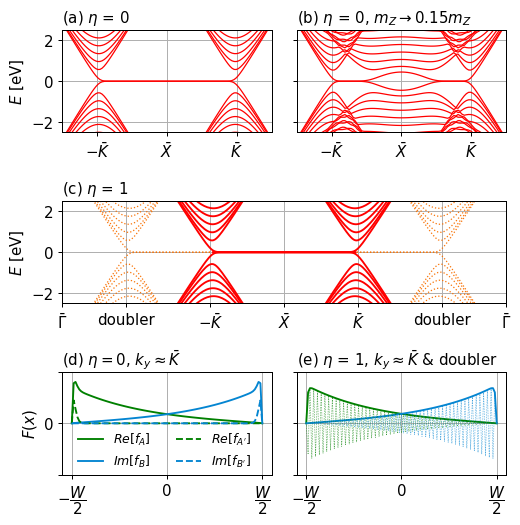

In [9]:
plt.rcParams.update({'font.size': 12})
plt.figure(dpi=90, figsize=(6,6))
#plt.text(0.02, 0.55, R"(a)", transform=plt.gca().transAxes)

################# AAAAAA #######################
plt.subplot(321)
plt.title(R"(a) $\eta$ = 0", {'fontsize': 12}, loc='left')
plt.plot(ky, bandasA/1000, lw=1, c='red')
plt.ylim([-2.5,2.5])
plt.xlim([-1.5*Dk, 1.5*Dk])
plt.xticks([-Dk, 0, Dk], [R"$-\bar{K}$", R"$\bar{X}$", R"$\bar{K}$"])
plt.grid()
#plt.xlabel(R'$k$ [nm$^{-1}$]')
plt.ylabel(R'$E$ [eV]')

################# BBBBBB #######################
plt.subplot(322)
plt.title(R"(b) $\eta$ = 0, $m_Z \rightarrow 0.15 m_Z$", {'fontsize': 12}, loc='left')
plt.plot(ky, bandasB/1000, lw=1, c='red')
plt.ylim([-2.5,2.5])
plt.xlim([-1.5*Dk, 1.5*Dk])
plt.xticks([-Dk, 0, Dk], [R"$-\bar{K}$", R"$\bar{X}$", R"$\bar{K}$"])
plt.tick_params(labelleft=False)
plt.grid()

################# CCCCCC #######################
plt.subplot(312)
plt.title(R"(c) $\eta$ = 1", {'fontsize': 12}, loc='left')
plt.plot(kyC[102:], bandasC1[102:,:]/1000, lw=1.5, c='red', ls='-')
plt.plot(kyC[:102], bandasC1[:102,:]/1000, lw=1, c='xkcd:orange', ls=':')
plt.plot(kyC[199:], bandasC2[199:,:]/1000, lw=1, c='xkcd:orange', ls=':')
plt.plot(kyC[:199], bandasC2[:199,:]/1000, lw=1.5, c='red', ls='-')
plt.ylim([-2.5,2.5])
plt.xlim([-3*Dk, 3*Dk])
doubler = Dk-(0.5*mw/(2*hvf))*(4/dx**2)
plt.xticks([doubler, -3*Dk, -Dk, 0, Dk, 3*Dk, -doubler], ["doubler", R"$\bar{\Gamma}$", R"$-\bar{K}$", R"$\bar{X}$", R"$\bar{K}$", R"$\bar{\Gamma}$", "doubler"])
plt.grid()
#plt.xlabel(R'$k$ [nm$^{-1}$]')
plt.ylabel(R'$E$ [eV]')

######################################
############# DENSITIES ##############
######################################

kpt = 0.5

# k2 correct
plt.subplot(325)
plt.title(R"(d) $\eta=0$, $k_y \approx \bar{K}$", {'fontsize': 12}, loc='left')
enk, psi = zigzag(x, [Dk-kpt], hvf, hvf, mw, 0, dens=True)
idp = 0
print("E =", enk[2*Nx+idp]/1000)
k2DensA1 = -np.real(psi[      :(Nx)  , 2*Nx+idp])
k2DensB1 = -np.imag(psi[  (Nx):(2*Nx), 2*Nx+idp])
k2DensA2 = -np.real(psi[(2*Nx):(3*Nx), 2*Nx+idp])
k2DensB2 = -np.imag(psi[(3*Nx):      , 2*Nx+idp])
# add zero
xp = np.concatenate(([0], x, [Lx]))
k2DensA1 = np.concatenate(([0], k2DensA1, [0]))
k2DensB1 = np.concatenate(([0], k2DensB1, [0]))
k2DensA2 = np.concatenate(([0], k2DensA2, [0]))
k2DensB2 = np.concatenate(([0], k2DensB2, [0]))
#
nrm = np.sum(k2DensA1**2*dx) + np.sum(k2DensB1**2*dx)
nrm += np.sum(k2DensA2**2*dx) + np.sum(k2DensB2**2*dx)
plt.plot(xp, k2DensA1/np.sqrt(nrm), label=R"$Re[f_A]$", c='green')
plt.plot(xp, k2DensB1/np.sqrt(nrm), label=R"$Im[f_B]$", c='xkcd:cerulean')
plt.plot(xp, k2DensA2/np.sqrt(nrm), ls='--', c='green', label=R"$Re[f_{A'}]$")
plt.plot(xp, k2DensB2/np.sqrt(nrm), ls='--', c='xkcd:cerulean', label=R"$Im[f_{B'}]$")
plt.xticks([xp[0], 0.5*xp[-1], xp[-1]], [R"$-\dfrac{W}{2}$", R"0", R"$\dfrac{W}{2}$"])
plt.ylim([-1,1])
#plt.tick_params(labelleft=False)
plt.yticks([-1,0,1], ["","0",""])
plt.ylabel(R"$F(x)$")
plt.legend(ncol=2, fontsize=10, frameon=False, loc=(0.05,0)) #loc='lower center')
plt.grid()

# k1 correct
plt.subplot(326)
plt.title(R"(e) $\eta$ = 1, $k_y \approx \bar{K}$ & doubler", {'fontsize': 12}, loc='left')
enk, psi = zigzag(x, [Dk-kpt], hvf, hvf, mw, 1, dens=True)
idp = 1
print("E =", enk[2*Nx+idp]/1000)
k2DensA1 = np.real(psi[      :(Nx)  , 2*Nx+idp])
k2DensB1 = np.imag(psi[  (Nx):(2*Nx), 2*Nx+idp])
k2DensA2 = np.real(psi[(2*Nx):(3*Nx), 2*Nx+idp])
k2DensB2 = np.imag(psi[(3*Nx):      , 2*Nx+idp])
# add zero
xp = np.concatenate(([0], x, [Lx]))
k2DensA1 = np.concatenate(([0], k2DensA1, [0]))
k2DensB1 = np.concatenate(([0], k2DensB1, [0]))
k2DensA2 = np.concatenate(([0], k2DensA2, [0]))
k2DensB2 = np.concatenate(([0], k2DensB2, [0]))
#
nrm = np.sum(k2DensA1**2*dx) + np.sum(k2DensB1**2*dx)
plt.plot(xp, k2DensA1/np.sqrt(nrm), c='green')
plt.plot(xp, k2DensB1/np.sqrt(nrm), c='xkcd:cerulean')
#plt.plot(xp, k2DensA2/np.sqrt(nrm))
#plt.plot(xp, k2DensB2/np.sqrt(nrm))

# k1 doubler
doubler = Dk-(mw/(2*hvf))*(4/dx**2)
enk, psi = zigzag(x, [doubler+kpt], hvf, hvf, mw, 1, dens=True)
idp = 0
print("E =", enk[2*Nx+idp]/1000)
k2DensA1 = -np.real(psi[      :(Nx)  , 2*Nx+idp])
k2DensB1 = -np.imag(psi[  (Nx):(2*Nx), 2*Nx+idp])
k2DensA2 = -np.real(psi[(2*Nx):(3*Nx), 2*Nx+idp])
k2DensB2 = -np.imag(psi[(3*Nx):      , 2*Nx+idp])
# add zero
xp = np.concatenate(([0], x, [Lx]))
k2DensA1 = np.concatenate(([0], k2DensA1, [0]))
k2DensB1 = np.concatenate(([0], k2DensB1, [0]))
k2DensA2 = np.concatenate(([0], k2DensA2, [0]))
k2DensB2 = np.concatenate(([0], k2DensB2, [0]))
#
nrm = np.sum(k2DensA1**2*dx) + np.sum(k2DensB1**2*dx)
plt.plot(xp, k2DensA1/np.sqrt(nrm), c='green', ls=':', lw=0.5)
plt.plot(xp, k2DensB1/np.sqrt(nrm), c='xkcd:cerulean', ls=':', lw=0.5)
#plt.plot(xp, k2DensA2/np.sqrt(nrm))
#plt.plot(xp, k2DensB2/np.sqrt(nrm))
#
#plt.tick_params(labelleft=False)
plt.yticks([-1,0,1], ["","",""])
plt.xticks([xp[0], 0.5*xp[-1], xp[-1]], [R"$-\dfrac{W}{2}$", R"0", R"$\dfrac{W}{2}$"])
plt.ylim([-1,1])
plt.grid()

plt.tight_layout()
#plt.savefig("zigzagbands.png");
#plt.savefig("zigzagbands.svg");

In [10]:
# run data for next figure: zigzag 48
# ribbon's size
Nd = 48 # dimers
Nz = 2*Nd # old notation
Lx = (3*Nd/2 +1)*a0
print("      Lx =", Lx, "nm = ", (3*Nz + 4)*a0/4)

# discretization
Nx = 4*Nz
x = np.linspace(0, Lx, Nx+2)[1:-1]
dx = x[1]-x[0]
# wilson
mw = wilson(dx, True)

      Lx = 10.366 nm =  10.366
    minf = 1.8123453533479505 meV.nm²
    msup = 86.64859459315919 meV.nm²
      mw = 44.23046997325357 meV.nm²


In [12]:
# bandas dft
dftRAW = np.loadtxt("DFT_Zigzag_"+str(Nz)+"/Bandas_"+str(Nz)+"-150.agr")
dft_nk = 150
dft_nb = int(dftRAW.shape[0]/dft_nk)
# organize bands to plot
dftK = (3*dftRAW[:dft_nk,0]-1)*Dk
dftE = dftRAW[:,1].reshape((dft_nb, dft_nk)).T

# bandas TB
tb = np.loadtxt("TB/tb-zigzag-bands-"+str(Nz)+".dat");
tb_k = np.linspace(-Dk, +2*Dk, tb.shape[0])
tbdensZ={}
tbdensZ[0]=np.loadtxt("TB/tb-zigzag-dens-"+str(Nz)+"-0.dat")
tbdensZ[1]=np.loadtxt("TB/tb-zigzag-dens-"+str(Nz)+"-1.dat")

# k1
ky1, bandas1 = zigzagk1(Lx, 0.8, "bandas")

In [13]:
# k2 - best parameters for the zigzag fit
hvx = 0.8*hvf
hvy = hvx
eta = 0
mz = -50
# armchair parameters - shift cone
ma = 0
theta = 2*np.pi/3
# other
Delta = 0 # shift
hmu = 0*hvf
mxy = 0

ky = np.linspace(-2, Dk/2, 101)
bandask2 = zigzag(x, ky-Dk/2, hvx, hvy, mw, eta, ma, theta, Delta, hmu, mxy, dens=False, cone=Dk/2)

In [18]:
# calculate the densities

# DFT data
KPOINT = 35 # 33, 34, 35
ids = [0, 1] # which band
bids = "c0 c1".split()
dftDens = {}
p2DensA = {}
p2DensB = {}
p2DensA1 = {}
p2DensB1 = {}
p2DensA2 = {}
p2DensB2 = {}
p1DensA = {}
p1DensB = {}
for id in ids:
    bid = bids[id] #Dens 148 k33 c0
    dftXDens = np.loadtxt("DFT_Zigzag_"+str(Nz)+"/K-point-"+str(KPOINT)+"/Dens_"+str(Nz)+"_k"+str(KPOINT)+"_"+bid+".dat")
    # converting DFT data to real numbers # point 33 = K
    kdft = (KPOINT-33)*Dk/33;
    dftX = a0 + dftXDens[:,0]
    dftDensId = dftXDens[:,1]/(np.sum(dftXDens[:,1])*np.diff(dftX)[0])
    dftDens[id] =dftDensId
    
    # k1
    p1DensAid, p1DensBid = zigzagk1(Lx, 0.8, "densidade", kdft, id+1, x, True)
    # normaliza densidades
    p1DensAid = np.abs(p1DensAid)**2
    p1DensBid = np.abs(p1DensBid)**2
    p1DensA[id] = p1DensAid/np.max(p1DensAid)
    p1DensB[id] = p1DensBid/np.max(p1DensBid)
    
    # k2
    xp = np.concatenate(([0], x, [Lx])) # to add point
    en, psi = zigzag(x, [kdft-Dk/2], hvx, hvy, mw, eta, ma, theta, Delta, hmu, mxy, dens=True, cone=Dk/2)
    #
    p2A1 = psi[0:Nx, 2*Nx+id]
    p2B1 = psi[Nx:(2*Nx), 2*Nx+id]
    p2A2 = psi[(2*Nx):(3*Nx), 2*Nx+id]
    p2B2 = psi[(3*Nx):(4*Nx), 2*Nx+id]
    # opt1
    p2DensA1[id] = np.abs(p2A1)**2
    p2DensB1[id] = np.abs(p2B1)**2
    p2DensA2[id] = np.abs(p2A2)**2
    p2DensB2[id] = np.abs(p2B2)**2
    nrm = np.max(np.concatenate((p2DensA1[id],p2DensA2[id],p2DensB1[id],p2DensB2[id])))
    p2DensA1[id] = p2DensA1[id]/nrm
    p2DensA2[id] = p2DensA2[id]/nrm
    p2DensB1[id] = p2DensB1[id]/nrm
    p2DensB2[id] = p2DensB2[id]/nrm    
    # add point
    p2DensA1[id] = np.concatenate(([0], p2DensA1[id], [0]))
    p2DensB1[id] = np.concatenate(([0], p2DensB1[id], [0]))
    p2DensA2[id] = np.concatenate(([0], p2DensA2[id], [0]))
    p2DensB2[id] = np.concatenate(([0], p2DensB2[id], [0]))
    # opt2
    p2DensA[id] = np.abs(p2A1+p2A2)**2
    p2DensB[id] = np.abs(p2B1+p2B2)**2
    p2DensA[id] = p2DensA[id]/np.max(p2DensA[id])
    p2DensB[id] = p2DensB[id]/np.max(p2DensB[id])
    # add point
    p2DensA[id] = np.concatenate(([0], p2DensA[id], [0]))
    p2DensB[id] = np.concatenate(([0], p2DensB[id], [0]))

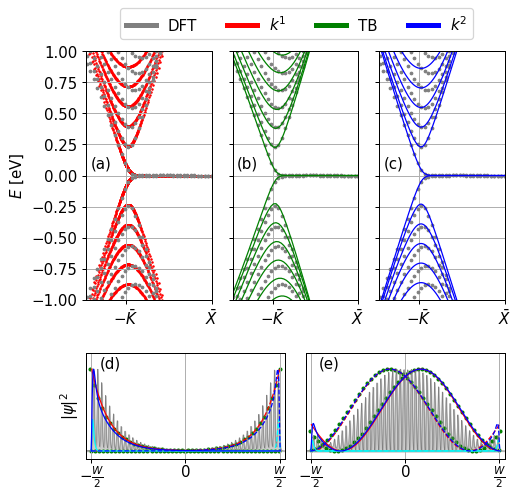

In [19]:
plt.figure(dpi=90, figsize=(6,6))
grid = plt.GridSpec(2, 6, wspace=0.4, hspace=0.3, height_ratios=[0.7, 0.3])

custom_lines = [
    Line2D([0], [0], color="gray", lw=4),
    Line2D([0], [0], color="red", lw=4),
    Line2D([0], [0], color="green", lw=4),
    Line2D([0], [0], color="blue", lw=4)
]

plt.subplot(grid[0, 0:2])
plt.text(0.12, 0.55, '(a)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.scatter(ky1, bandas1/1000, color="red", s=1.0)
plt.ylim([-1,1]);
plt.xlim([-2,Dk/2]);
plt.xticks([0, Dk/2], [R"$-\bar{K}$", R"$\bar{X}$"])
plt.ylabel(R"$E$ [eV]");
plt.grid();

plt.subplot(grid[0, 2:4])
plt.text(0.12, 0.55, '(b)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.plot(tb_k, 2.4*tb, color='green', lw=1);
plt.tick_params(labelleft=False)
plt.ylim([-1,1]);
plt.xlim([-2,Dk/2]);
plt.xticks([0, Dk/2], [R"$-\bar{K}$", R"$\bar{X}$"])
#plt.xlabel(R"$k_y$ [nm$^{-1}$]");
plt.grid();

plt.legend(custom_lines, ("DFT", "$k^1$", "TB", "$k^2$"), ncol=4, loc=[-0.9,1.05])

plt.subplot(grid[0, 4:6])
plt.text(0.12, 0.55, '(c)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.plot(ky, bandask2/1000, color='blue', lw=1);
plt.tick_params(labelleft=False)
plt.ylim([-1,1]);
plt.xlim([-2,Dk/2]);
plt.xticks([0, Dk/2], [R"$-\bar{K}$", R"$\bar{X}$"])
plt.grid();

fixnrm = [3,1]
for idp in range(2):
    #plt.subplot(223+idp)
    plt.subplot(grid[1, (0+3*idp):(3+3*idp)])
    # dft
    plt.plot(dftX, dftDens[idp]/np.max(dftDens[idp]), color="gray", linewidth=0.5)
    plt.fill_between(dftX, 0, dftDens[idp]/np.max(dftDens[idp]), color="gray", alpha=0.4)
    # k1
    plt.plot(x, p1DensA[idp], color="red", linewidth=1, ls="-")
    plt.plot(x, p1DensB[idp], color="red", linewidth=1, ls="--")
    # k2 opt 1
    plt.plot(xp, p2DensA1[idp], color="cyan", linewidth=1, ls="-")
    plt.plot(xp, p2DensB1[idp], color="cyan", linewidth=1, ls="--")
    plt.plot(xp, p2DensA2[idp], color="blue", linewidth=1, ls="-")
    plt.plot(xp, p2DensB2[idp], color="blue", linewidth=1, ls="--")
    # k2 opt 2
    #plt.plot(xp, fixnrm[idp]*p2DensA[idp], color="blue", linewidth=1, ls="-")
    #plt.plot(xp, fixnrm[idp]*p2DensB[idp], color="blue", linewidth=1, ls="--")
    # tb
    sites = tbdensZ[idp][:,0]*Lx/np.max(tbdensZ[idp][:,0])
    plt.scatter(sites, tbdensZ[idp][:,1]/np.max(tbdensZ[idp][:,1]), marker="o", s=5, color="green")
    #
    plt.tick_params(axis='x', which='major', pad=0)
    if idp==0:
        plt.ylabel(R"$|\psi|^2$")
        plt.text(0.12, 0.90, '(d)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    else:
        plt.text(0.12, 0.90, '(e)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.yticks([])
    plt.xlim([-2*a0, x[-1]+2*a0])
    plt.xticks([0, 0.5*x[-1], x[-1]], [R"$-\frac{W}{2}$", R"$0$", R"$\frac{W}{2}$"])
    plt.ylim([-0.1,1.2])
    plt.grid()

#plt.savefig("zigzag-"+str(Nz)+".png", bbox_inches='tight')
#plt.savefig("zigzag-"+str(Nz)+".svg", bbox_inches='tight')
plt.show()

# Armchair

Codes for the quadratic and k-linear models

In [11]:
# INPUT:
#     x: vector, all x points
#    kx: vector, k-points to calculate the energies
# hvx/y: hbar*fermi velocities
#    ma: wilson's mass (armchair)
# theta: boundary condition (armchair)
#
# OPTIONAL PARAMETERS FOR FITTING
#  Kbar: center of the Dirac cones (Dk?)
#    mz: wilson's mass (zigzag)
#   eta: boundary condition (zigzag)
# Delta: affects gap
#   hmu: dispersion
#   mxy: dispersion
#
# DENSITY OUTPUT
#  dens: return or not the density
def armchair(y, kx, hvx, hvy, ma, theta, Kbar=0, mz=0, eta=0, Delta=0, hmu=0, mxy=0, dens=False):
    # step
    dy = y[1]-y[0]
    Ny = len(y)
    Nk = len(kx)
    
    # matrices to compose the discrete operators
    idN = np.eye(Ny)
    diagP = np.diag(np.ones(Ny-1), +1 )
    diagM = np.diag(np.ones(Ny-1), -1 )
    # operators
    ky  = (-1j/(2*dy))*(diagP - diagM)
    ky2 = -(diagP -2*idN + diagM)/(dy**2)

    def evals(qx, vecs=False):
        # minimal model
        h  = (1+0j)*hvx*np.kron(U0x, idN)*qx                  # hvx
        h += hvy*np.kron(Uzy, ky)                             # hvy
        h += hvy*np.kron(U0y, Kbar*idN)                       # Kbar
        cot = 1.0/np.tan(theta)
        csc = 1.0/np.sin(theta)
        h += 0.5*ma*np.kron(cot*U0y + csc*Uxy, ky2)           # ma, theta
        # other terms
        h += 0.5*mz*np.kron(eta*U0y + (1-eta)*Uxy, idN)*qx**2 # mz, eta
        h += Delta*np.kron(Uxy, idN)                          # Delta
        h += hmu*np.kron(Uxx, idN)*qx                         # hmu
        h += mxy*np.kron(Uzx, qx*ky)                          # mxy
        
        if vecs==False:
            return( np.linalg.eigvalsh(h) )
        else:
            return( np.linalg.eigh(h) )
    # fim evals

    if dens == False:
        autoval = np.array([])
        for qx in kx:
            eigval = evals(qx)
            autoval = np.append(autoval, eigval)
        autoval = autoval.reshape((Nk, 4*Ny))
        return autoval
    else: # dens == True
        return evals(kx[0], True)

In [12]:
def armchairk1(Na, Nqx, v1, theta, task, id=0, Ny=0):
    L = (Na+1)*np.sqrt(3)*a0/2
    
    if task == "bandas":
        # eixo kx
        kx = np.linspace(-0.5*ZBa, 0.5*ZBa, Nqx)
        listE = np.array([], dtype=np.float)
        nbandas = 15
        for n in range(-nbandas, +nbandas):
            kn = n*np.pi/L + np.arccos(np.cos(2*theta))/(2*L)
            en = hbar*v1*np.sqrt(kx**2 + kn**2)
            listE = np.append(listE, +en)
            listE = np.append(listE, -en)
        listE = listE.reshape((4*nbandas, Nqx))
        return kx, listE.T

    if task == "densidade":
        listE = np.array([], dtype=np.float)
        nbandas = 15
        nrange = range(-nbandas, +nbandas)
        for n in nrange:
            kn = n*np.pi/L + np.arccos(np.cos(2*theta))/(2*L)
            en = hbar*v1*np.abs(kn)
            listE = np.append(listE, +en)
        listE = np.sort(listE)
        y  = np.linspace(0, L, Ny)
        #
        if np.mod(Na,3) == 0:
            dens = np.sin( listE[id]*y/(hbar*v1) + ((-1)**id)*(theta/2 + theta*(y-L/2)/L) )**2
        else:
            dens = np.sin( listE[id]*y/(hbar*v1) - ((-1)**id)*(theta/2 + theta*(y-L/2)/L) )**2

        return y, dens

# Armchair DFT gap

From the minimal models:

$E_{3p} = \dfrac{\hbar v_F}{L}\Big[\dfrac{2\pi}{3} - 2\Delta\theta\Big]$

$E_{3p+1} = \dfrac{\hbar v_F}{L}\Big[\dfrac{2\pi}{3} + 2\Delta\theta\Big]$

$E_{3p+2} = \dfrac{\hbar v_F}{L}\Big[2\Delta\theta\Big]$

In all cases, $E = \alpha/L$, thus $ln(E) = ln(\alpha) - ln(L)$.

In [13]:
# linear regression
def linreg(x, y):
    # averages
    xbar = np.mean(x)
    ybar = np.mean(y)
    xybar = np.mean(x*y)
    x2bar = np.mean(x*x)
    # coef angular
    a = (xybar-xbar*ybar)/(x2bar-xbar**2)
    # linear coef
    b = ybar - a*xbar
    return(a, b)

In [14]:
# DFT data
dft = np.loadtxt("DFT.gap.armchair.agr")

# fitted linear coefficients
# 3p
lnL0 = np.log((dft[0:16, 0]+1)*np.sqrt(3)*a0/2)
lnE0 = np.log(dft[0:16, 1])
um, lnalpha0 = linreg(lnL0, lnE0)
print("  (3p) angular coeff =", um)
# 3p+1
lnL1 = np.log((dft[16:32, 0]+1)*np.sqrt(3)*a0/2)
lnE1 = np.log(dft[16:32, 1])
um, lnalpha1 = linreg(lnL1, lnE1)
print("(3p+1) angular coeff =", um)
# 3p+2
lnL2 = np.log((dft[32:48, 0]+1)*np.sqrt(3)*a0/2)
lnE2 = np.log(dft[32:48, 1])
um, lnalpha2 = linreg(lnL2, lnE2)
print("(3p+2) angular coeff =", um)

  (3p) angular coeff = -0.9540668338896814
(3p+1) angular coeff = -0.9987600561896424
(3p+2) angular coeff = -0.9907979039698864


In [15]:
# fit functions
def deltatheta3p(fracfermi):
    return np.rad2deg(+np.pi/3-np.exp(lnalpha0)/(2*1e-3*hvf*fracfermi))

def deltatheta3p1(fracfermi):
    return np.rad2deg(-np.pi/3+np.exp(lnalpha1)/(2*1e-3*hvf*fracfermi))

def deltatheta3p2(fracfermi):
    return np.rad2deg(np.exp(lnalpha2)/(2*1e-3*hvf*fracfermi))

print("For vx=vy=   vf, dtheta =", np.around(deltatheta3p(1), decimals=1), "#", np.around(deltatheta3p1(1), decimals=1), "#", np.around(deltatheta3p2(1), decimals=1))
print("For vx=vy=0.8vf, dtheta =", np.around(deltatheta3p(0.8), decimals=1), "#", np.around(deltatheta3p1(0.8), decimals=1), "#", np.around(deltatheta3p2(0.8), decimals=1))

For vx=vy=   vf, dtheta = 29.4 # 6.5 # 15.8
For vx=vy=0.8vf, dtheta = 21.7 # 23.1 # 19.8


In [16]:
# reduced Fermi velocity
vfrac = 0.8 # for all minimal model that follows

# testing
dtheta0 = np.around(deltatheta3p(vfrac), decimals=1)
dtheta1 = np.around(deltatheta3p1(vfrac), decimals=1)
dtheta2 = np.around(deltatheta3p2(vfrac), decimals=1)

# pure BF
def gapBF(Na, theta=0):
    thetaBF = theta + (Na+1)*2*np.pi/3
    nc = np.ceil(thetaBF/np.pi)
    nf = np.floor(thetaBF/np.pi)
    L = (Na+1)*np.sqrt(3)*a0/2
    e1 = vfrac*hvf*(+nc*np.pi-thetaBF)/L
    e2 = vfrac*hvf*(-nc*np.pi-thetaBF)/L
    e3 = vfrac*hvf*(+nf*np.pi-thetaBF)/L
    e4 = vfrac*hvf*(-nf*np.pi-thetaBF)/L
    return np.min(np.abs([e1,e2,e3,e4]))

plist = np.array(range(1,18))
gapBF0 = np.array([gapBF(3*p, np.deg2rad(dtheta0)) for p in plist])/1000
gapBF1 = np.array([gapBF(3*p+1, np.deg2rad(dtheta1)) for p in plist])/1000
gapBF2 = np.array([gapBF(3*p+2, np.deg2rad(dtheta2)) for p in plist])/1000

In [17]:
# bands vs size
gap0 = [] # 3p
gap1 = [] # 3p+1
gap2 = [] # 3p+2
for p in plist:
    Nyf = 3 # define number of points
    kbar = 0
    
    # 3p
    Na = 3*p
    Ny  = 1+Nyf*(Na+1)
    Ly = (Na+1)*np.sqrt(3)*a0/2
    thetaBF = (Na+1)*2*np.pi/3
    theta = thetaBF + np.deg2rad(dtheta0)
    y = np.linspace(0, Ly, Ny)
    dy = y[1]-y[0]
    mw = wilson(dy, False)
    gap0.append( np.abs( armchair(y, [0], vfrac*hvf, vfrac*hvf, -mw, theta, kbar) ).min()/1000 )

    # 3p+1
    Na = 3*p+1
    Ny  = 1+Nyf*(Na+1)
    Ly = (Na+1)*np.sqrt(3)*a0/2
    thetaBF = (Na+1)*2*np.pi/3
    theta = thetaBF + np.deg2rad(dtheta1)
    y = np.linspace(0, Ly, Ny)
    dy = y[1]-y[0]
    mw = wilson(dy, False)
    gap1.append( np.abs( armchair(y, [0], vfrac*hvf, vfrac*hvf, -mw, theta, kbar) ).min()/1000 )
    
    # 3p+2
    Na = 3*p+2
    Ny  = 1+Nyf*(Na+1)
    Ly = (Na+1)*np.sqrt(3)*a0/2
    thetaBF = (Na+1)*2*np.pi/3
    theta = thetaBF + np.deg2rad(dtheta2)
    y = np.linspace(0, Ly, Ny)
    dy = y[1]-y[0]
    mw = wilson(dy, False)
    gap2.append( np.abs( armchair(y, [0], vfrac*hvf, vfrac*hvf, -mw, theta, kbar) ).min()/1000 )

gap0 = np.array(gap0)
gap1 = np.array(gap1)
gap2 = np.array(gap2)

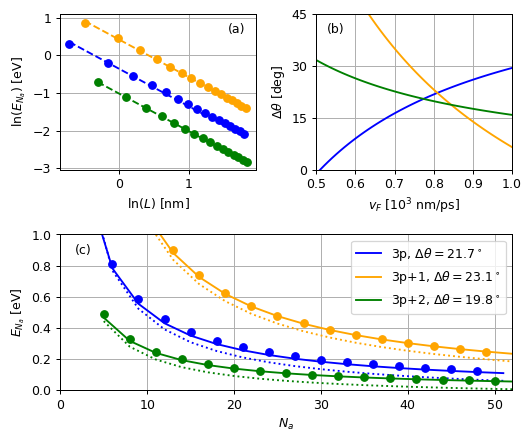

In [18]:
plt.figure(dpi=90, figsize=(6,5))

# fit alpha
plt.subplot(221) 
plt.text(0.9, 0.9, '(a)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# 3p
plt.plot(lnL0, lnE0, "o", color="blue")
plt.plot(lnL0, lnalpha0 - lnL0, color="blue", ls='--')
# 3p+1
plt.plot(lnL1, lnE1, "o", color="orange")
plt.plot(lnL1, lnalpha1 - lnL1, color="orange", ls='--')
#3p+2
plt.plot(lnL2, lnE2, "o", color="green")
plt.plot(lnL2, lnalpha2 - lnL2, color="green", ls='--')
#
plt.xlabel(R"$\ln(L)$ [nm]")
plt.ylabel(R"$\ln(E_{N_a})$ [eV]")
plt.grid()

plt.subplot(222)
plt.text(0.1, 0.9, '(b)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
vfrac = np.linspace(0.5, 1.0, 50) # fraction of the fermi velocity
plt.plot(vfrac, deltatheta3p(vfrac), color='blue')
plt.plot(vfrac, deltatheta3p1(vfrac), color='orange')
plt.plot(vfrac, deltatheta3p2(vfrac), color='green')
plt.xlabel(R"$v_F$ [$10^3$ nm/ps]")
plt.ylabel(R"$\Delta\theta$ [deg]")
plt.yticks(np.linspace(0,45,4))
plt.xticks(np.linspace(0.5,1.0, 6))
plt.ylim([0,45])
plt.xlim([0.5, 1.0])
plt.grid()


plt.subplot(212)
plt.text(0.05, 0.9, '(c)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
shiftBF = 0.05
# 3p
plt.plot(3*plist, 2*gap0, ls="-", label=R"3p, $\Delta\theta ="+str(dtheta0)+"^\circ$", color="blue")
plt.plot(3*plist, 2*gapBF0-shiftBF, ls=":", color="blue")
plt.plot(dft[0:16, 0], dft[0:16, 1], "o", color="blue")
# 3p+1
plt.plot(3*plist+1, 2*gap1, ls="-", label=R"3p+1, $\Delta\theta ="+str(dtheta1)+"^\circ$", color="orange")
plt.plot(3*plist+1, 2*gapBF1-shiftBF, ls=":", color="orange")
plt.plot(dft[16:32, 0], dft[16:32, 1], "o", color="orange")
# 3p+2
plt.plot(3*plist+2, 2*gap2, ls="-", label=R"3p+2, $\Delta\theta ="+str(dtheta2)+"^\circ$", color="green")
plt.plot(3*plist+2, 2*gapBF2-shiftBF, ls=":", color="green")
plt.plot(dft[32:48, 0], dft[32:48, 1], "o", color="green")
#
plt.ylabel(R"$E_{N_a}$ [eV]")
plt.xlabel(R"$N_a$")
plt.ylim([0,1])
plt.xlim([0,52])
plt.legend()
plt.grid();

plt.tight_layout();
#plt.savefig("armchairgap.png");
#plt.savefig("armchairgap.svg");

# Fit Armchair 48

In [19]:
# ribbon's size
Na = 48
Ly = (Na+1)*np.sqrt(3)*a0/2
print("      Ly =", Ly, "nm")

# theta
thetaBF = (Na+1)*2*np.pi/3
print(" thetaBF =", thetaBF, "rad =", np.mod(np.rad2deg(thetaBF), 360), "°")

# discretization
Ny  = 1+3*(Na+1)
print("      Ny =", Ny)
y = np.linspace(0, Ly, Ny)
dy = y[1]-y[0]

# wilson
mw = wilson(dy, True)

# kspace
kxmax = 2 #dftK[-1]
kx = np.linspace(-kxmax, kxmax, 101)

      Ly = 6.025804759532123 nm
 thetaBF = 102.62536001726657 rad = 120.0 °
      Ny = 148
    minf = 4.200833333333332 meV.nm²
    msup = 86.64859459315919 meV.nm²
      mw = 45.42471396324626 meV.nm²


In [23]:
# bandas dft
dftRAW  = np.loadtxt("DFT_Armchair_"+str(Na)+"/Bandas_"+str(Na)+"-150.agr")
dft_nk = 150
dft_nb = int(dftRAW.shape[0]/dft_nk)
# organize bands to plot
dftK = (dftRAW[:dft_nk,0]*np.sqrt(3)-0.5)*ZBa
dftE = dftRAW[:,1].reshape((dft_nb, dft_nk)).T

# bandas TB
tb = np.loadtxt("TB/tb-armchair-bands-"+str(Na)+".dat");
tb_k = np.linspace(-ZBa/2, ZBa/2, tb.shape[0])

# gaps
print("GAPS:")
print("-- from Brey-Fertig:", 2*gapBF(Na, np.deg2rad(dtheta0))/1000, "eV")
print("---------- from DFT:", 2*np.min(np.abs(dftE)), "eV")

GAPS:
-- from Brey-Fertig: 0.07301748147130503 eV
---------- from DFT: 0.1253061294 eV


In [24]:
#### PARAMETERS

theta = thetaBF + np.deg2rad( np.around(deltatheta3p(0.8), decimals=1) );
# terms that affect gap at kx=0
hvy = 0.8*hvf
ma = 50
Delta = 0
# terms that define the dispersion itself
hvx = hvy
hmu = 0.1*hvf
mxy = -ma
# zigzag terms
mz = -ma
eta = 0 # 0=nosso, 1=BF
#
Kbar = 0 # projeção do K
# k-linear
vf1 = 0.8*vf

#### BANDS

bandas48 = armchair(y, kx, hvx, hvy, ma, theta, Kbar, mz, eta, Delta, hmu, mxy, dens=False)/1000
ky1, bandas48k1 = armchairk1(Na, 101, vf1, theta, task="bandas")

#### DENSITY
tbdens48={}
tbdens48[0]=np.loadtxt("TB/tb-armchair-dens-48-0.dat")
tbdens48[1]=np.loadtxt("TB/tb-armchair-dens-48-1.dat")

KPOINT = "00" # 00, 05, 07, 08, 09, 10
ids = [0, 1]
bids = "c0 c1".split()
dftDens = {}
dens2 = {}
dens1 = {}
for id in ids:
    bid = bids[id]
    dftXDens = np.loadtxt("DFT_Armchair_"+str(Na)+"/K-point-"+ KPOINT +"/Dens_"+str(Na)+"_k"+ KPOINT +"_"+bid+".dat")
    # ajuste unidades DFT # 0 = 100 = X, 50 = Gamma
    kdft = int(KPOINT)*ZBa/100.0
    dftX = 0.5*np.sqrt(3.0)*a0 + dftXDens[:,0]
    dftDens[id] = dftXDens[:,1]/(np.sum(dftXDens[:,1])*np.diff(dftX)[0])

    # modelo k2
    en, psi = armchair(y, [kdft], hvx, hvy, ma, theta, Kbar, mz, eta, Delta, hmu, mxy, dens=True)
    p2A1 = psi[0:Ny, 2*Ny+id]
    p2B1 = psi[Ny:(2*Ny), 2*Ny+id]
    p2A2 = psi[(2*Ny):(3*Ny), 2*Ny+id]
    p2B2 = psi[(3*Ny):(4*Ny), 2*Ny+id]
    nrm = np.sqrt(np.sum(np.abs(p2A1)**2+np.abs(p2B1)**2+np.abs(p2A2)**2+np.abs(p2B2)**2)*dy)
    fase = np.exp(1j*theta*y/Ly)*np.exp(-1j*theta/2)
    dens2[id] = np.abs(p2A1*fase + p2A2/fase)**2/nrm

    # modelo k1
    y1, dens1[id] = armchairk1(Na, 101, vf1, theta, task="densidade", id=id, Ny=5*Ny)

In [25]:
plt.figure(dpi=90, figsize=(6,6))
grid = plt.GridSpec(2, 6, wspace=0.4, hspace=0.3, height_ratios=[0.7, 0.3])

custom_lines = [
    Line2D([0], [0], color="gray", lw=4),
    Line2D([0], [0], color="red", lw=4),
    Line2D([0], [0], color="green", lw=4),
    Line2D([0], [0], color="blue", lw=4)
]

plt.subplot(grid[0, 0:2])
plt.text(0.12, 0.55, '(a)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.plot(ky1, bandas48k1/1000, c="red", lw=1);
plt.ylim([-1,1]);
plt.xlim([-kxmax,kxmax]);
plt.ylabel(R"$E$ [eV]");
plt.grid();

plt.subplot(grid[0, 2:4])
plt.text(0.12, 0.55, '(b)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.plot(tb_k, 2.4*tb, color='green', lw=1);
plt.tick_params(labelleft=False)
plt.ylim([-1,1]);
plt.xlim([-kxmax,kxmax]);
plt.xlabel(R"$k_x$ [nm$^{-1}$]");
plt.grid();

plt.legend(custom_lines, ("DFT", "$k^1$", "TB", "$k^2$"), ncol=4, loc=[-0.9,1.05])

plt.subplot(grid[0, 4:6])
plt.text(0.12, 0.55, '(c)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.plot(kx, bandas48, color='blue', lw=1);
plt.tick_params(labelleft=False)
plt.ylim([-1,1]);
plt.xlim([-kxmax,kxmax]);
plt.grid();


for idp in range(2):
    #plt.subplot(223+idp)
    plt.subplot(grid[1, (0+3*idp):(3+3*idp)])
    
    plt.plot(dftX, dftDens[idp]/np.max(dftDens[idp]), color="gray", linewidth=2, ms=10)
    plt.fill_between(dftX, 0, dftDens[idp]/np.max(dftDens[idp]), color="gray", alpha=0.4)
    #
    densinter2 = interp1d(y, dens2[idp])
    densinter1 = interp1d(y1, dens1[idp])
    sites = np.arange(1,Na+1,1)*np.sqrt(3)*a0/2
    plt.scatter(sites, densinter1(sites)/np.max(densinter1(sites)), s=75, color="blue", marker="x");
    plt.scatter(sites, densinter2(sites)/np.max(densinter2(sites)), s=25, color="red");
    #
    plt.scatter(sites, tbdens48[idp][:,1]/np.max(tbdens48[idp][:,1]), marker="o", s=50, facecolors='none', edgecolors="green");
    #
    plt.tick_params(axis='x', which='major', pad=0)
    if idp==0:
        plt.ylabel(R"$|\psi|^2$")
        plt.text(0.12, 0.90, '(d)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    else:
        plt.text(0.12, 0.90, '(e)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.yticks([])
    plt.xlim([-2*a0, y[-1]+2*a0])
    plt.xticks([0, 0.5*y[-1], y[-1]], [R"$-\frac{L}{2}$", R"$0$", R"$\frac{L}{2}$"])
    plt.ylim([-0.1,1.2])
    plt.grid()

#plt.savefig("armchair-"+str(Na)+".png", bbox_inches='tight')
#plt.savefig("armchair-"+str(Na)+".svg", bbox_inches='tight')
plt.show()

# Fit armchair 49

In [35]:
Na = 49
Ly = (Na+1)*np.sqrt(3)*a0/2
print("      Ly =", Ly, "nm")

# theta
thetaBF = (Na+1)*2*np.pi/3
print(" thetaBF =", thetaBF, "rad =", np.mod(np.rad2deg(thetaBF), 360), "°")

# discretization
Ny = 1+3*(Na+1)
print("      Ny =", Ny)
y = np.linspace(0, Ly, Ny)
dy = y[1]-y[0]

# wilson
mw = wilson(dy, True)

# kspace
kxmax = 2 #dftK[-1]
kx = np.linspace(-kxmax, kxmax, 101)

      Ly = 6.148780366869514 nm
 thetaBF = 104.71975511965978 rad = 240.0000000000009 °
      Ny = 151
    minf = 4.200833333333333 meV.nm²
    msup = 86.64859459315919 meV.nm²
      mw = 45.42471396324626 meV.nm²


In [37]:
# bandas dft
dftRAW  = np.loadtxt("DFT_Armchair_"+str(Na)+"/Bandas_"+str(Na)+"-150.agr")
dft_nk = 150
dft_nb = int(dftRAW.shape[0]/dft_nk)
# organize bands to plot
dftK = (dftRAW[:dft_nk,0]*np.sqrt(3)-0.5)*ZBa
dftE = dftRAW[:,1].reshape((dft_nb, dft_nk)).T

# bandas TB
tb = np.loadtxt("TB/tb-armchair-bands-"+str(Na)+".dat");
tb_k = np.linspace(-ZBa/2, ZBa/2, tb.shape[0])

# gaps
print("GAPS:")
print("-- from Brey-Fertig:", 2*gapBF(Na, np.deg2rad(dtheta1))/1000, "eV")
print("---------- from DFT:", 2*np.min(np.abs(dftE)), "eV")

GAPS:
-- from Brey-Fertig: 0.15525842444021104 eV
---------- from DFT: 0.24777937 eV


In [39]:
#### PARAMETERS

theta = thetaBF + np.deg2rad( np.around(deltatheta3p1(0.8), decimals=1) );
# terms that affect gap at kx=0
hvy = 0.8*hvf
ma = 50
Delta = 0
# terms that define the dispersion itself
hvx = hvy
hmu = -0.05*hvf
mxy = -ma
# zigzag terms
mz = -ma
eta = 0 # 0=nosso, 1=BF
#
Kbar = 0 # projeção do K
# k-linear
vf1 = 0.8*vf

#### BANDS

bandas49 = armchair(y, kx, hvx, hvy, ma, theta, Kbar, mz, eta, Delta, hmu, mxy, dens=False)/1000
ky1, bandas49k1 = armchairk1(Na, 101, vf1, theta, task="bandas")

#### DENSITY
tbdens49={}
tbdens49[0]=np.loadtxt("TB/tb-armchair-dens-49-0.dat")
tbdens49[1]=np.loadtxt("TB/tb-armchair-dens-49-1.dat")

KPOINT = "00" # 00, 05, 07, 08, 09, 10
ids = [0, 1]
bids = "c0 c1".split()
dftDens = {}
dens2 = {}
dens1 = {}
for id in ids:
    bid = bids[id]
    dftXDens = np.loadtxt("DFT_Armchair_"+str(Na)+"/K-point-"+ KPOINT +"/Dens_"+str(Na)+"_k"+ KPOINT +"_"+bid+".dat")
    # ajuste unidades DFT # 0 = 100 = X, 50 = Gamma
    kdft = int(KPOINT)*ZBa/100.0
    dftX = 0.5*np.sqrt(3.0)*a0 + dftXDens[:,0]
    dftDens[id] = dftXDens[:,1]/(np.sum(dftXDens[:,1])*np.diff(dftX)[0])

    # modelo k2
    en, psi = armchair(y, [kdft], hvx, hvy, ma, theta, Kbar, mz, eta, Delta, hmu, mxy, dens=True)
    p2A1 = psi[0:Ny, 2*Ny+id]
    p2B1 = psi[Ny:(2*Ny), 2*Ny+id]
    p2A2 = psi[(2*Ny):(3*Ny), 2*Ny+id]
    p2B2 = psi[(3*Ny):(4*Ny), 2*Ny+id]
    nrm = np.sqrt(np.sum(np.abs(p2A1)**2+np.abs(p2B1)**2+np.abs(p2A2)**2+np.abs(p2B2)**2)*dy)
    fase = np.exp(1j*theta*y/Ly)*np.exp(-1j*theta/2)
    dens2[id] = np.abs(p2A1*fase + p2A2/fase)**2/nrm

    # modelo k1
    y1, dens1[id] = armchairk1(Na, 101, vf1, theta, task="densidade", id=id, Ny=5*Ny)

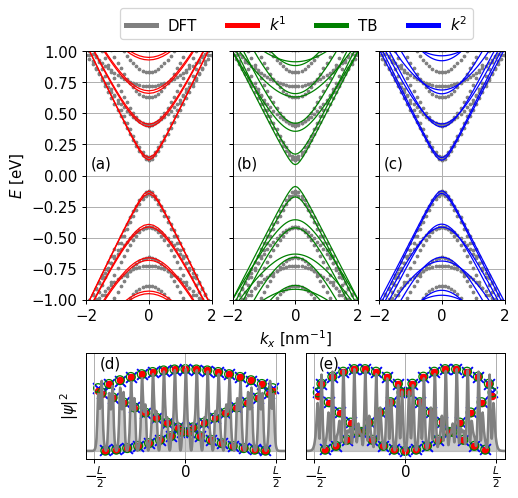

In [40]:
plt.figure(dpi=90, figsize=(6,6))
grid = plt.GridSpec(2, 6, wspace=0.4, hspace=0.3, height_ratios=[0.7, 0.3])

custom_lines = [
    Line2D([0], [0], color="gray", lw=4),
    Line2D([0], [0], color="red", lw=4),
    Line2D([0], [0], color="green", lw=4),
    Line2D([0], [0], color="blue", lw=4)
]

plt.subplot(grid[0, 0:2])
plt.text(0.12, 0.55, '(a)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.plot(ky1, bandas49k1/1000, c="red", lw=1);
plt.ylim([-1,1]);
plt.xlim([-kxmax,kxmax]);
plt.ylabel(R"$E$ [eV]");
plt.grid();

plt.subplot(grid[0, 2:4])
plt.text(0.12, 0.55, '(b)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.plot(tb_k, 2.4*tb, color='green', lw=1);
plt.tick_params(labelleft=False)
plt.ylim([-1,1]);
plt.xlim([-kxmax,kxmax]);
plt.xlabel(R"$k_x$ [nm$^{-1}$]");
plt.grid();

plt.legend(custom_lines, ("DFT", "$k^1$", "TB", "$k^2$"), ncol=4, loc=[-0.9,1.05])

plt.subplot(grid[0, 4:6])
plt.text(0.12, 0.55, '(c)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.plot(kx, bandas49, color='blue', lw=1);
plt.tick_params(labelleft=False)
plt.ylim([-1,1]);
plt.xlim([-kxmax,kxmax]);
plt.grid();

for idp in range(2):
    #plt.subplot(223+idp)
    plt.subplot(grid[1, (0+3*idp):(3+3*idp)])
    
    plt.plot(dftX, dftDens[idp]/np.max(dftDens[idp]), color="gray", linewidth=2, ms=10)
    plt.fill_between(dftX, 0, dftDens[idp]/np.max(dftDens[idp]), color="gray", alpha=0.4)
    #
    densinter2 = interp1d(y, dens2[idp])
    densinter1 = interp1d(y1, dens1[idp])
    sites = np.arange(1,Na+1,1)*np.sqrt(3)*a0/2
    plt.scatter(sites, densinter1(sites)/np.max(densinter1(sites)), s=75, color="blue", marker="x");
    plt.scatter(sites, densinter2(sites)/np.max(densinter2(sites)), s=25, color="red");
    #
    plt.scatter(sites, tbdens49[idp][:,1]/np.max(tbdens49[idp][:,1]), marker="o", s=50, facecolors='none', edgecolors="green");
    #
    plt.tick_params(axis='x', which='major', pad=0)
    if idp==0:
        plt.ylabel(R"$|\psi|^2$")
        plt.text(0.12, 0.90, '(d)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    else:
        plt.text(0.12, 0.90, '(e)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.yticks([])
    plt.xlim([-2*a0, y[-1]+2*a0])
    plt.xticks([0, 0.5*y[-1], y[-1]], [R"$-\frac{L}{2}$", R"$0$", R"$\frac{L}{2}$"])
    plt.ylim([-0.1,1.2])
    plt.grid()

#plt.savefig("armchair-"+str(Na)+".png", bbox_inches='tight')
#plt.savefig("armchair-"+str(Na)+".svg", bbox_inches='tight')
plt.show()

# Fit Armchair 50

In [41]:
# ribbon's size
Na = 50
Ly = (Na+1)*np.sqrt(3)*a0/2
print("      Ly =", Ly, "nm")

# theta
thetaBF = (Na+1)*2*np.pi/3
print(" thetaBF =", thetaBF, "rad =", np.mod(np.rad2deg(thetaBF), 360), "°")

# discretization
Ny  = 1+2*(Na+1)
print("      Ny =", Ny)
y = np.linspace(0, Ly, Ny)
dy = y[1]-y[0]

# wilson
mw = wilson(dy, True)

# kspace
kxmax = 2 #dftK[-1]
kx = np.linspace(-kxmax, kxmax, 101)

      Ly = 6.271755974206903 nm
 thetaBF = 106.81415022205296 rad = 0.0 °
      Ny = 103
    minf = 9.451874999999996 meV.nm²
    msup = 86.64859459315919 meV.nm²
      mw = 48.050234796579595 meV.nm²


In [42]:
# bandas dft
dftRAW  = np.loadtxt("DFT_Armchair_"+str(Na)+"/Bandas_"+str(Na)+"-150.agr")
dft_nk = 150
dft_nb = int(dftRAW.shape[0]/dft_nk)
# organize bands to plot
dftK = (dftRAW[:dft_nk,0]*np.sqrt(3)-0.5)*ZBa
dftE = dftRAW[:,1].reshape((dft_nb, dft_nk)).T

# bandas TB
tb = np.loadtxt("TB/tb-armchair-bands-"+str(Na)+".dat");
tb_k = np.linspace(-ZBa/2, ZBa/2, tb.shape[0])

# gaps
print("GAPS:")
print("-- from Brey-Fertig:", 2*gapBF(Na, np.deg2rad(dtheta2))/1000, "eV")
print("---------- from DFT:", 2*np.min(np.abs(dftE)), "eV")

GAPS:
-- from Brey-Fertig: 0.03626762940841512 eV
---------- from DFT: 0.0588126182 eV


In [43]:
#### PARAMETERS

theta = thetaBF + np.deg2rad( np.around(deltatheta3p2(0.8), decimals=1) );
# terms that affect gap at kx=0
hvy = 0.8*hvf
ma = 50
Delta = 0
# terms that define the dispersion itself
hvx = hvy
hmu = 0*hvf
mxy = -ma
# zigzag terms
mz = -ma
eta = 0 # 0=nosso, 1=BF
#
Kbar = 0 # projeção do K
# k-linear
vf1 = 0.8*vf

#### BANDS

bandas50 = armchair(y, kx, hvx, hvy, ma, theta, Kbar, mz, eta, Delta, hmu, mxy, dens=False)/1000
ky1, bandas50k1 = armchairk1(Na, 101, vf1, theta, task="bandas")

#### DENSITY
tbdens50={}
tbdens50[0]=np.loadtxt("TB/tb-armchair-dens-50-0.dat")
tbdens50[1]=np.loadtxt("TB/tb-armchair-dens-50-1.dat")

KPOINT = "00" # 00, 05, 07, 08, 09, 10
ids = [0, 1]
bids = "c0 c1".split()
dftDens = {}
dens2 = {}
dens1 = {}
for id in ids:
    bid = bids[id]
    dftXDens = np.loadtxt("DFT_Armchair_"+str(Na)+"/K-point-"+ KPOINT +"/Dens_"+str(Na)+"_k"+ KPOINT +"_"+bid+".dat")
    # ajuste unidades DFT # 0 = 100 = X, 50 = Gamma
    kdft = int(KPOINT)*ZBa/100.0
    dftX = 0.5*np.sqrt(3.0)*a0 + dftXDens[:,0]
    dftDens[id] = dftXDens[:,1]/(np.sum(dftXDens[:,1])*np.diff(dftX)[0])

    # modelo k2
    en, psi = armchair(y, [kdft], hvx, hvy, ma, theta, Kbar, mz, eta, Delta, hmu, mxy, dens=True)
    p2A1 = psi[0:Ny, 2*Ny+id]
    p2B1 = psi[Ny:(2*Ny), 2*Ny+id]
    p2A2 = psi[(2*Ny):(3*Ny), 2*Ny+id]
    p2B2 = psi[(3*Ny):(4*Ny), 2*Ny+id]
    nrm = np.sqrt(np.sum(np.abs(p2A1)**2+np.abs(p2B1)**2+np.abs(p2A2)**2+np.abs(p2B2)**2)*dy)
    fase = np.exp(1j*theta*y/Ly)*np.exp(-1j*theta/2)
    dens2[id] = np.abs(p2A1*fase + p2A2/fase)**2/nrm

    # modelo k1
    y1, dens1[id] = armchairk1(Na, 101, vf1, theta, task="densidade", id=id, Ny=5*Ny)

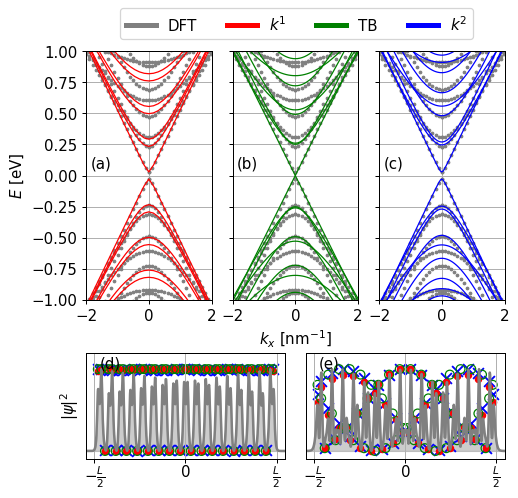

In [44]:
plt.figure(dpi=90, figsize=(6,6))
grid = plt.GridSpec(2, 6, wspace=0.4, hspace=0.3, height_ratios=[0.7, 0.3])

custom_lines = [
    Line2D([0], [0], color="gray", lw=4),
    Line2D([0], [0], color="red", lw=4),
    Line2D([0], [0], color="green", lw=4),
    Line2D([0], [0], color="blue", lw=4)
]

plt.subplot(grid[0, 0:2])
plt.text(0.12, 0.55, '(a)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.plot(ky1, bandas50k1/1000, c="red", lw=1);
plt.ylim([-1,1]);
plt.xlim([-kxmax,kxmax]);
plt.ylabel(R"$E$ [eV]");
plt.grid();

plt.subplot(grid[0, 2:4])
plt.text(0.12, 0.55, '(b)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.plot(tb_k, 2.4*tb, color='green', lw=1);
plt.tick_params(labelleft=False)
plt.ylim([-1,1]);
plt.xlim([-kxmax,kxmax]);
plt.xlabel(R"$k_x$ [nm$^{-1}$]");
plt.grid();

plt.legend(custom_lines, ("DFT", "$k^1$", "TB", "$k^2$"), ncol=4, loc=[-0.9,1.05])

plt.subplot(grid[0, 4:6])
plt.text(0.12, 0.55, '(c)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.plot(dftK, dftE,  'o', color='gray', ms=2);
plt.plot(kx, bandas50, color='blue', lw=1);
plt.tick_params(labelleft=False)
plt.ylim([-1,1]);
plt.xlim([-kxmax,kxmax]);
plt.grid();

for idp in range(2):
    #plt.subplot(223+idp)
    plt.subplot(grid[1, (0+3*idp):(3+3*idp)])
    
    plt.plot(dftX, dftDens[idp]/np.max(dftDens[idp]), color="gray", linewidth=2, ms=10)
    plt.fill_between(dftX, 0, dftDens[idp]/np.max(dftDens[idp]), color="gray", alpha=0.4)
    #
    densinter2 = interp1d(y, dens2[idp])
    densinter1 = interp1d(y1, dens1[idp])
    sites = np.arange(1,Na+1,1)*np.sqrt(3)*a0/2
    plt.scatter(sites, densinter1(sites)/np.max(densinter1(sites)), s=75, color="blue", marker="x");
    plt.scatter(sites, densinter2(sites)/np.max(densinter2(sites)), s=25, color="red");
    #
    plt.scatter(sites, tbdens50[idp][:,1]/np.max(tbdens50[idp][:,1]), marker="o", s=50, facecolors='none', edgecolors="green");
    #
    plt.tick_params(axis='x', which='major', pad=0)
    if idp==0:
        plt.ylabel(R"$|\psi|^2$")
        plt.text(0.12, 0.90, '(d)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    else:
        plt.text(0.12, 0.90, '(e)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.yticks([])
    plt.xlim([-2*a0, y[-1]+2*a0])
    plt.xticks([0, 0.5*y[-1], y[-1]], [R"$-\frac{L}{2}$", R"$0$", R"$\frac{L}{2}$"])
    plt.ylim([-0.1,1.2])
    plt.grid()

#plt.savefig("armchair-"+str(Na)+".png", bbox_inches='tight')
#plt.savefig("armchair-"+str(Na)+".svg", bbox_inches='tight')
plt.show()